In [83]:
import os
import glob
import shutil
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import FuncFormatter
import numpy as np
import pandas as pd
import os
import seaborn as sns
import json
from matplotlib.colors import LinearSegmentedColormap

def clear_folder_make_ess_pv(folder_path):
    if os.path.isdir(folder_path):
        shutil.rmtree(folder_path)
    os.makedirs(folder_path)
    os.makedirs(os.path.join(folder_path,'ess'))
    os.makedirs(os.path.join(folder_path,'pv'))

folder_path = 'plots'
clear_folder_make_ess_pv(folder_path)

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from EnergySystem import EnergySystem
from config import pv_config, grid_config, ess_config


In [85]:
import json

print("Version 0.0.5")

with open('config.json', 'r') as f:
    js_data = json.load(f)


    

time_interval = js_data["time_interval"]["numerator"] / js_data["time_interval"]["denominator"]
# print(time_interval)

pv_loss = js_data["pv"]["loss"]
pv_cost_per_kW = js_data["pv"]["cost_per_kW"]
pv_lifetime = js_data["pv"]["lifetime"]

ess_loss = js_data["ess"]["loss"]
ess_cost_per_kW = js_data["ess"]["cost_per_kW"]
ess_lifetime = js_data["ess"]["lifetime"]

grid_loss = js_data["grid"]["loss"]
sell_price = js_data["grid"]["sell_price"] #kWh
grid_capacity = js_data["grid"]["capacity"] #kWh

pv_begin = js_data["pv_capacities"]["begin"]
pv_end = js_data["pv_capacities"]["end"]
pv_groups = js_data["pv_capacities"]["groups"]

ess_begin = js_data["ess_capacities"]["begin"]
ess_end = js_data["ess_capacities"]["end"]
ess_groups = js_data["ess_capacities"]["groups"]

annot_unmet = js_data["annotated"]["unmet_prob"]
annot_benefit = js_data["annotated"]["benefit"]
annot_cost = js_data["annotated"]["cost"]
annot_roi = js_data["annotated"]["roi"]

title_unmet = js_data["plot_title"]["unmet_prob"]
title_cost = js_data["plot_title"]["cost"]
title_benefit = js_data["plot_title"]["benefit"]
title_roi = js_data["plot_title"]["roi"]


figure_size = (js_data["figure_size"]["length"], js_data["figure_size"]["height"])

data = pd.read_csv('combined_data.csv')

granularity = js_data["time_interval"]["numerator"]

months_days = [31,28,31,30,31,30,31,31,30,31,30,31]
def get_month_coe(num, granularity):
    return 60 / granularity * 24 * months_days[num]

months_index = [get_month_coe(num, granularity) for num in range(12)]
months_data = []
for i in range(1,12):
    months_index[i] += months_index[i-1]
for i in range(12):
    start = 0 if i == 0 else months_index[i-1]
    end = months_index[i]
    months_data.append(data.iloc[int(start):int(end)])
    



pv_capacities = np.linspace(pv_begin, pv_end, pv_groups)
ess_capacities = np.linspace(ess_begin, ess_end, ess_groups)
# results = pd.DataFrame(index=pv_capacities, columns= ess_capacities)
# affords = pd.DataFrame(index=pv_capacities, columns= ess_capacities)
# costs = pd.DataFrame(index=pv_capacities, columns= ess_capacities)
# overload_cnt = pd.DataFrame(index=pv_capacities, columns= ess_capacities)


Version 0.0.5


In [86]:
hour_demand = []
for index, row in data.iterrows():
    time = row['time']
    demand = row['demand']
    if time.endswith('00'):
        hour_demand.append(demand)
plt.figure(figsize=(10,8))
plt.plot(hour_demand)
plt.ylabel('Demand Power / kW')
plt.savefig('plots/demand.png')
plt.close()

In [87]:
def draw_results(results, filename, title_benefit, annot_benefit=False, figure_size=(10, 10)):
    df=results
    df = df.astype(float)
    df.index = df.index / 1000
    df.index = df.index.map(int)
    df.columns = df.columns / 1000
    df.columns = df.columns.map(int)
    min_value = df.min().min()
    max_value = df.max().max()
    max_scale = max(abs(min_value/1000), abs(max_value/1000))

    df[df.columns[-1] + 1] = df.iloc[:, -1] 
    new_Data = pd.DataFrame(index=[df.index[-1] + 1], columns=df.columns)
    for i in df.columns:
        new_Data[i] = df[i].iloc[-1]
    df = pd.concat([df, new_Data])

    X, Y = np.meshgrid(np.arange(df.shape[1]), np.arange(df.shape[0]))

    def fmt(x,pos):
        return '{:.0f}'.format(x/1000)

    cmap = sns.color_palette("coolwarm", as_cmap=True)
    plt.figure(figsize=figure_size)
    ax = sns.heatmap(df/1000, fmt=".1f", cmap=cmap, vmin=-max_scale, vmax=max_scale, annot=annot_benefit)
    CS = ax.contour(X, Y, df,  colors='black', alpha=0.5)
    ax.clabel(CS, inline=True, fontsize=10, fmt=FuncFormatter(fmt))
    plt.title(title_benefit)
    plt.gca().invert_yaxis()
    plt.xlim(0, df.shape[1] - 1)
    plt.ylim(0, df.shape[0] - 1)
    plt.xlabel('ESS Capacity (MWh)')
    plt.ylabel('PV Capacity (MW)')
    plt.savefig(filename)

In [88]:
def draw_roi(costs, results, filename, title_roi, days=365, annot_roi=False, figure_size=(10, 10)):
    costs = costs.astype(float)
    costs = costs / 365 
    costs = costs * days

    df = results
    df = costs / df
    if 0 in df.index and 0 in df.columns:
        df.loc[0,0] = 100
    df[df > 80] = 100
    # print(df)

    df = df.astype(float)
    df.index = df.index / 1000
    df.index = df.index.map(int)
    df.columns = df.columns / 1000
    df.columns = df.columns.map(int)
    min_value = df.min().min()
    max_value = df.max().max()
    # print(max_value)
    max_scale = max(abs(min_value), abs(max_value))

    df[df.columns[-1] + 1] = df.iloc[:, -1] 
    new_Data = pd.DataFrame(index=[df.index[-1] + 1], columns=df.columns)
    for i in df.columns:
        new_Data[i] = df[i].iloc[-1]
    df = pd.concat([df, new_Data])

    X, Y = np.meshgrid(np.arange(df.shape[1]), np.arange(df.shape[0]))

    def fmt(x,pos):
        return '{:.0f}'.format(x)

    cmap = sns.color_palette("Greys", as_cmap=True)
    plt.figure(figsize=figure_size)
    ax = sns.heatmap(df, fmt=".1f", cmap=cmap, vmin=0, vmax=100, annot=annot_benefit)
    CS = ax.contour(X, Y, df,  colors='black', alpha=0.5)
    ax.clabel(CS, inline=True, fontsize=10, fmt=FuncFormatter(fmt))
    plt.title(title_roi)
    plt.gca().invert_yaxis()
    plt.xlim(0, df.shape[1] - 1)
    plt.ylim(0, df.shape[0] - 1)
    plt.xlabel('ESS Capacity (MWh)')
    plt.ylabel('PV Capacity (MW)')
    plt.savefig(filename)
    plt.close()

In [89]:
def draw_cost(costs, filename, title_cost, annot_cost=False, figure_size=(10, 10)):
    df = costs
    df = df.astype(int)
    df.index = df.index / 1000
    df.index = df.index.map(int)
    df.columns = df.columns / 1000
    df.columns = df.columns.map(int)

    df[df.columns[-1] + 1] = df.iloc[:, -1] 
    new_Data = pd.DataFrame(index=[df.index[-1] + 1], columns=df.columns)
    for i in df.columns:
        new_Data[i] = df[i].iloc[-1]
    df = pd.concat([df, new_Data])
    X, Y = np.meshgrid(np.arange(df.shape[1]), np.arange(df.shape[0]))

    def fmt(x, pos):
        return '{:.0f}'.format(x / 1000000)

    plt.figure(figsize=figure_size)
    ax = sns.heatmap(df/1000000,  fmt=".1f", cmap='viridis', annot=annot_cost)
    CS = ax.contour(X, Y, df,  colors='black', alpha=0.5)
    ax.clabel(CS, inline=True, fontsize=10, fmt=FuncFormatter(fmt))
    plt.title(title_cost)
    plt.gca().invert_yaxis()
    plt.xlim(0, df.shape[1] - 1)
    plt.ylim(0, df.shape[0] - 1)
    plt.xlabel('ESS Capacity (MWh)')
    plt.ylabel('PV Capacity (MW)')
    plt.savefig(filename)
    plt.close()

In [90]:
def draw_overload(overload_cnt, filename, title_unmet, annot_unmet=False, figure_size=(10, 10), days=365, granularity=15):
    df = overload_cnt
    # print(days, granularity)
    coef = 60 / granularity * days * 24
    # print(coef)
    # print(df)
    df = ( coef - df) / coef
    # print(df)

    df = df.astype(float)
    df.index = df.index / 1000
    df.index = df.index.map(int)
    df.columns = df.columns / 1000
    df.columns = df.columns.map(int)


    df[df.columns[-1] + 1] = df.iloc[:, -1] 
    new_Data = pd.DataFrame(index=[df.index[-1] + 1], columns=df.columns)
    for i in df.columns:
        new_Data[i] = df[i].iloc[-1]
    # print(new_Data)
    df = pd.concat([df, new_Data])


    plt.figure(figsize=figure_size)
    cmap = LinearSegmentedColormap.from_list("", ["white", "blue"])
    ax = sns.heatmap(df, fmt=".00%", cmap=cmap, vmin=0, vmax=1, annot=annot_unmet)

    cbar = ax.collections[0].colorbar
    cbar.set_ticks([0, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 1])
    cbar.set_ticklabels(['0%', '10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%'])
    cbar.ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x:.0%}'))
    X, Y = np.meshgrid(np.arange(df.shape[1]), np.arange(df.shape[0]))

    def fmt(x, pos):
        return '{:.0f}%'.format(x * 100)
    CS = ax.contour(X, Y, df,  colors='black', alpha=0.5)

    ax.clabel(CS, inline=True, fontsize=10, fmt=FuncFormatter(fmt))

    plt.xlim(0, df.shape[1] - 1)
    plt.ylim(0, df.shape[0] - 1)
    plt.title(title_unmet)
    plt.xlabel('ESS Capacity (MWh)')
    plt.ylabel('PV Capacity (MW)')
    plt.savefig(filename)
    plt.close()

In [91]:
def cal_profit(es: EnergySystem, saved_money, days):
    profit = saved_money - es.ess.get_cost_per_year() / 365 * days - es.pv.get_cost_per_year() / 365 * days
    return profit

In [92]:
def generate_data(pv_capacity, pv_cost_per_kW, pv_lifetime, pv_loss, ess_capacity, ess_cost_per_kW, ess_lifetime, ess_loss, grid_capacity, grid_loss, sell_price, time_interval, data, days, storage=0):
    pv = pv_config(capacity=pv_capacity, 
                    cost_per_kW=pv_cost_per_kW,
                    lifetime=pv_lifetime, 
                    loss=pv_loss)
    ess = ess_config(capacity=ess_capacity, 
                        cost_per_kW=ess_cost_per_kW, 
                        lifetime=ess_lifetime, 
                        loss=ess_loss,
                        charge_power=ess_capacity,
                        discharge_power=ess_capacity,
                        storage=storage)
    grid = grid_config(capacity=grid_capacity, 
                        grid_loss=grid_loss,
                        sell_price= sell_price)
    energySystem = EnergySystem(pv_type=pv, 
                                ess_type=ess, 
                                grid_type= grid)
    (benefit, netto_benefit, gen_energy) = energySystem.simulate(data, time_interval)
    results = cal_profit(energySystem, benefit, days)
    overload_cnt = energySystem.overload_cnt
    costs = energySystem.ess.capacity * energySystem.ess.cost_per_kW + energySystem.pv.capacity * energySystem.pv.cost_per_kW
    return (results, 
            overload_cnt,
            costs, 
            netto_benefit, 
            gen_energy, 
            energySystem.generated,
            energySystem.ess_rest,
            energySystem.factory_demand,
            energySystem.buy_price_kWh,
            energySystem.sell_price_kWh,
            energySystem.pv_generated_kWh,
            energySystem.grid_need_power_kW,
            energySystem.time)



  0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_1064872/4078438238.py:64: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2390.212877551013' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  months_ess_rest.loc[pv_capacity, ess_capacity] = ess_rest
/tmp/ipykernel_1064872/4078438238.py:64: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2390.212877551013' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  months_ess_rest.loc[pv_capacity, ess_capacity] = ess_rest
100%|██████████| 12/12 [00:19<00:00,  1.63s/it]


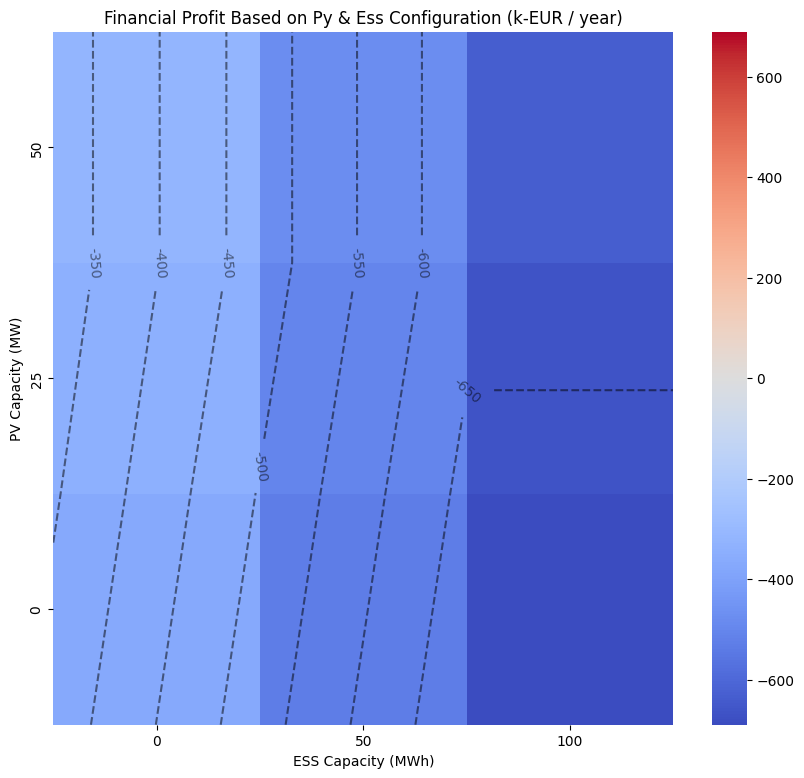

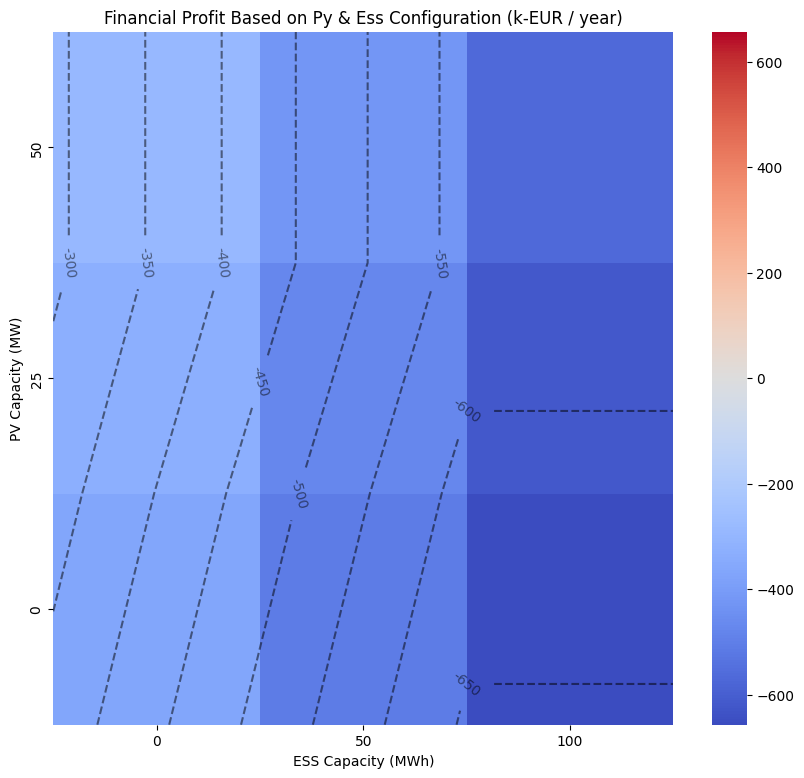

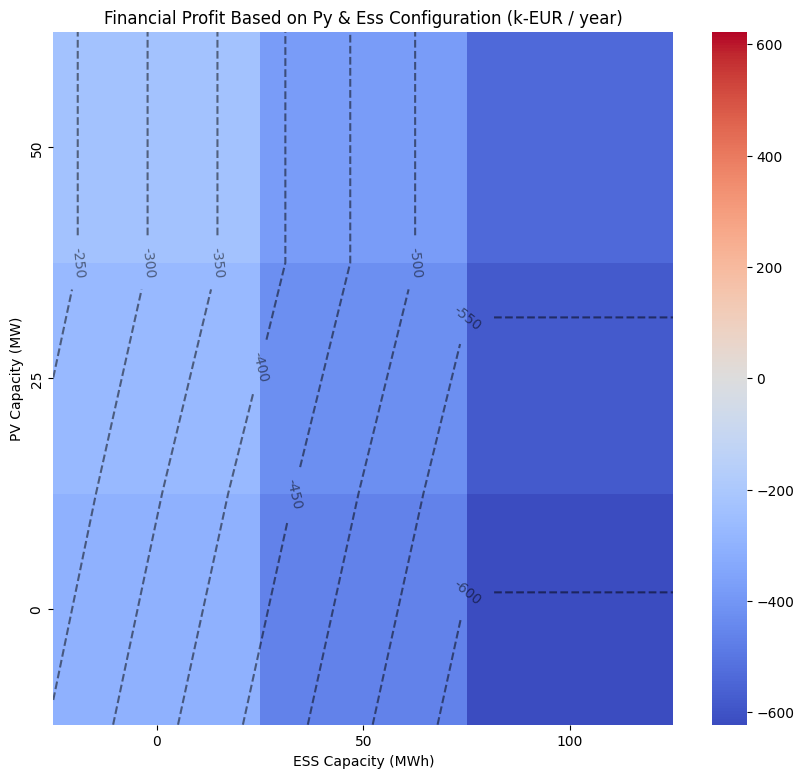

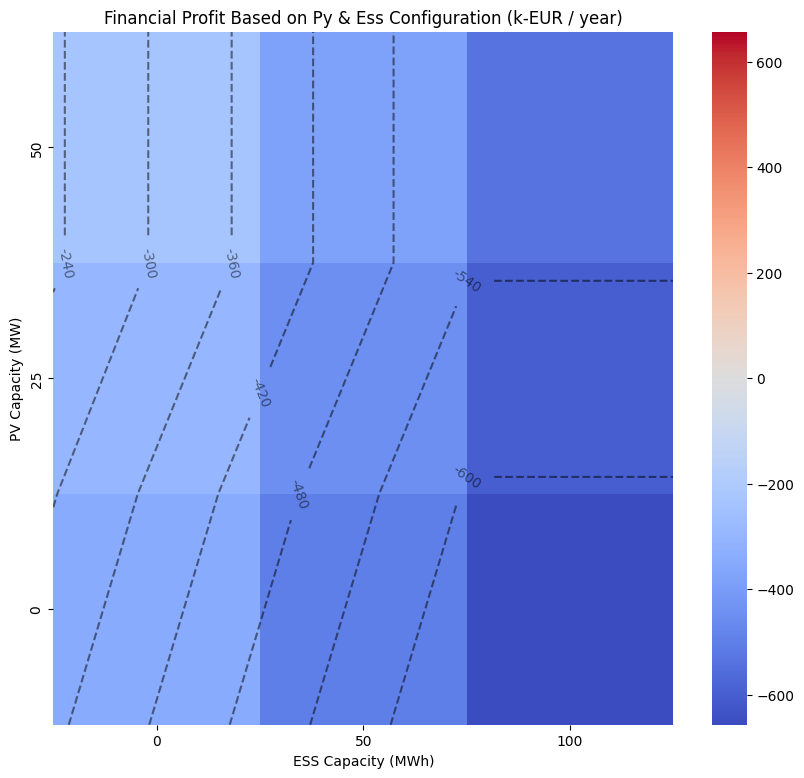

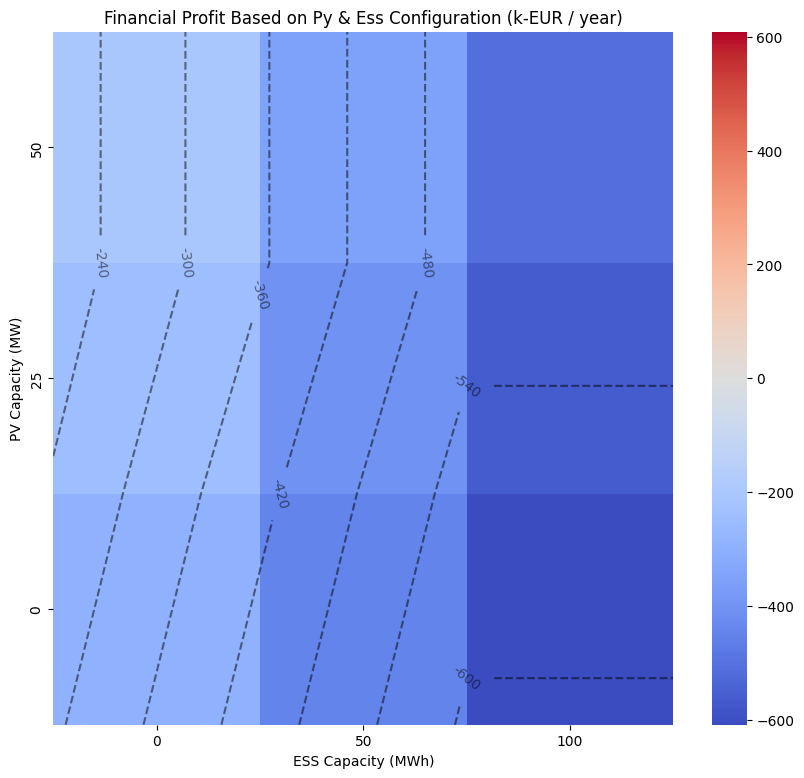

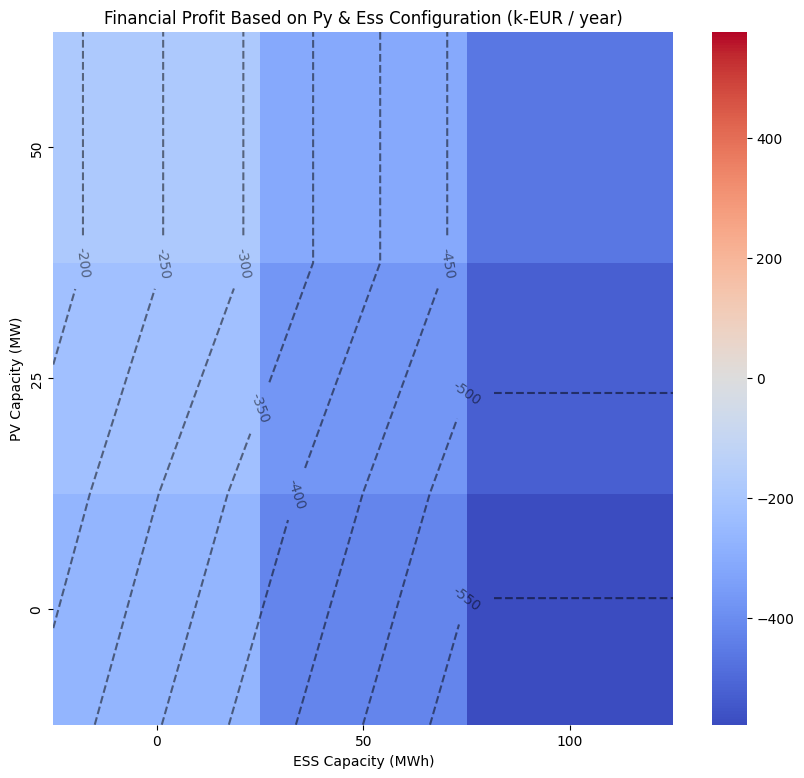

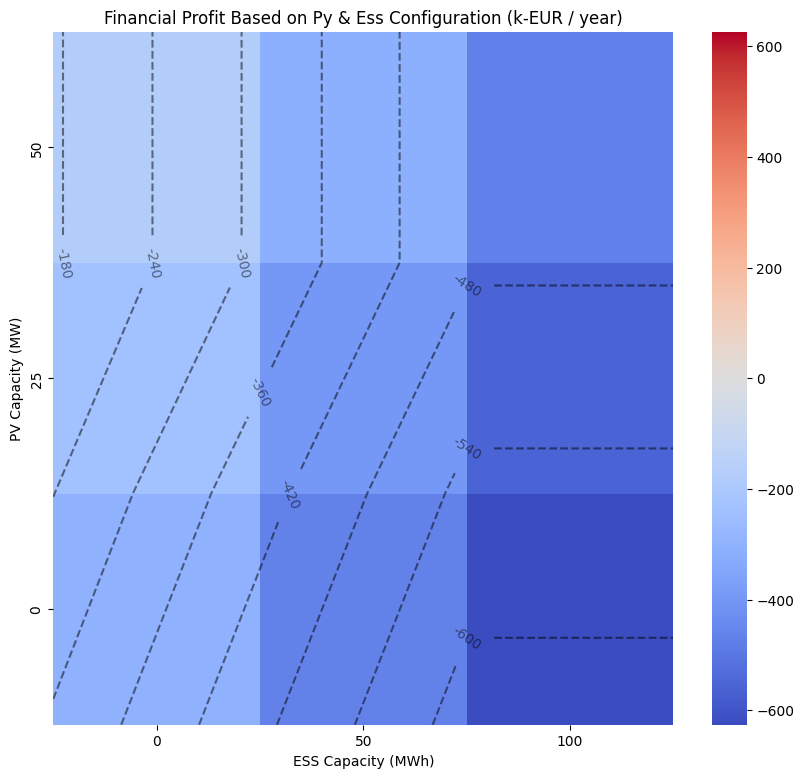

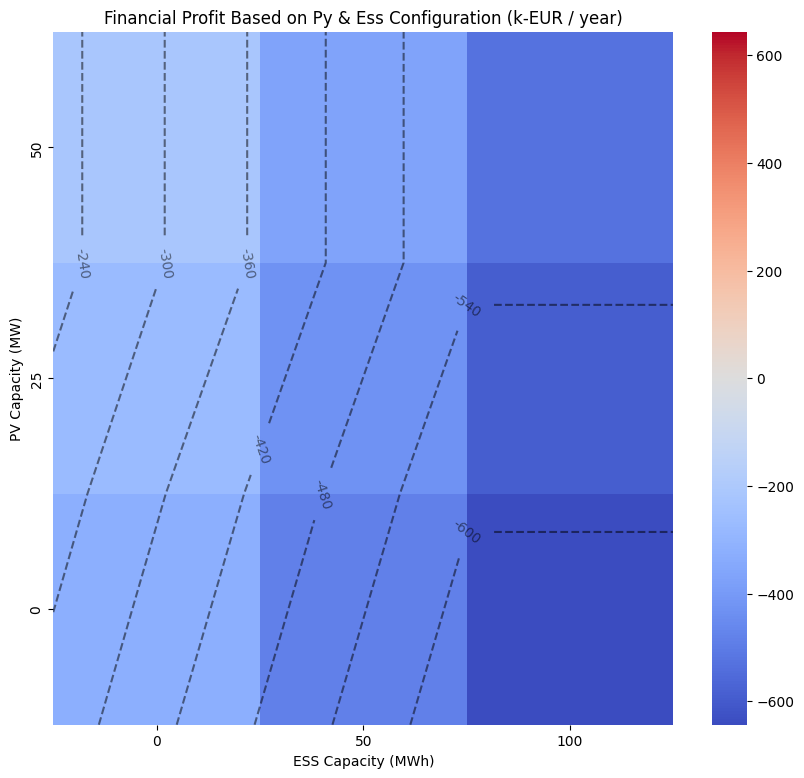

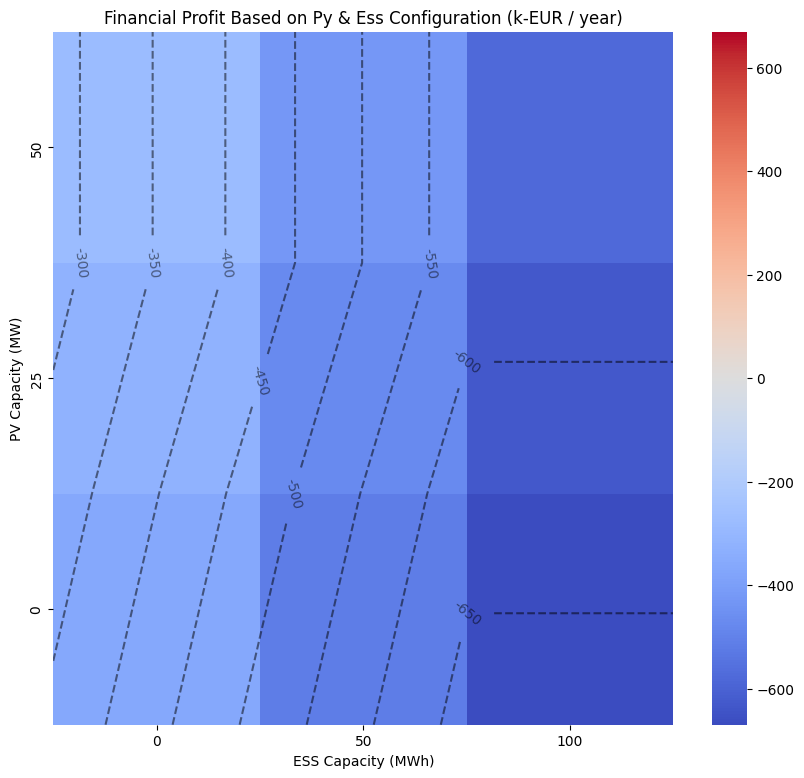

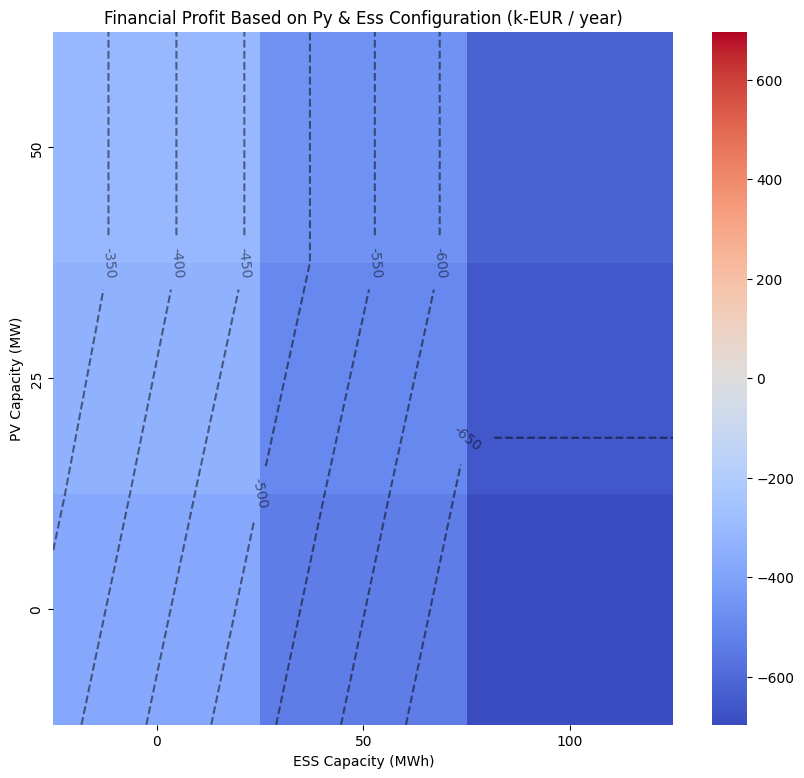

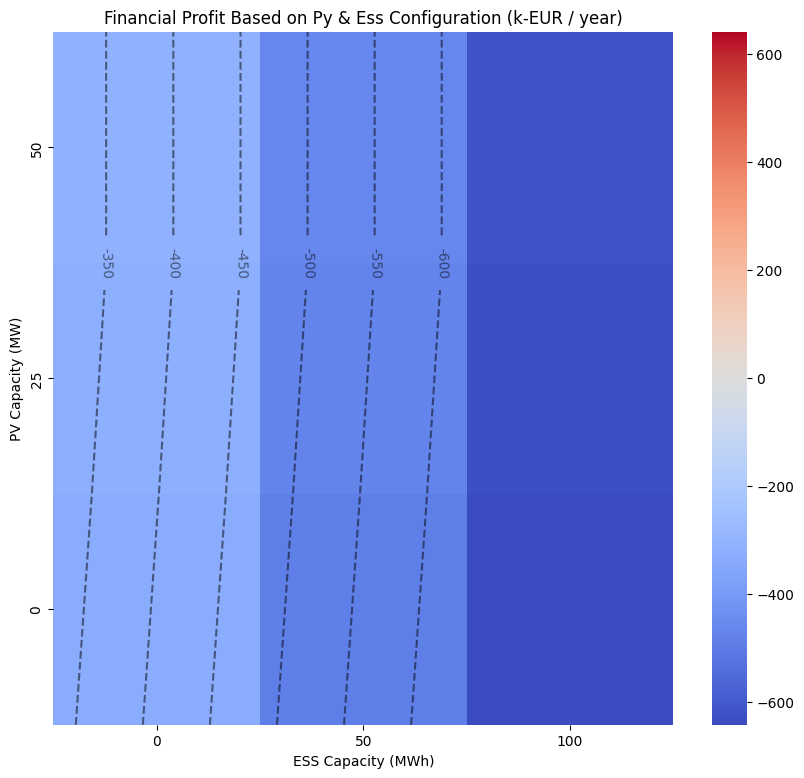

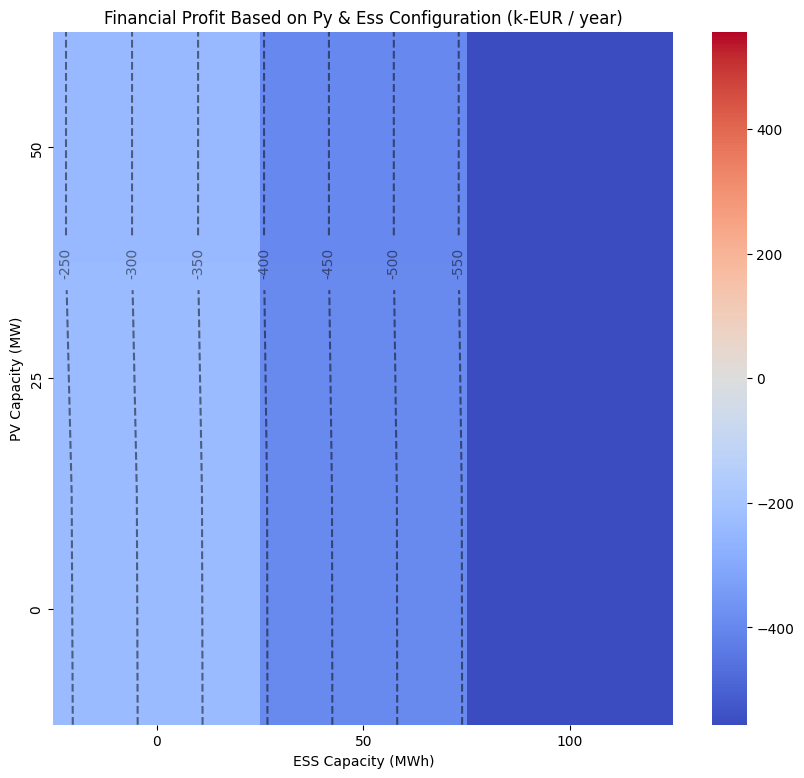

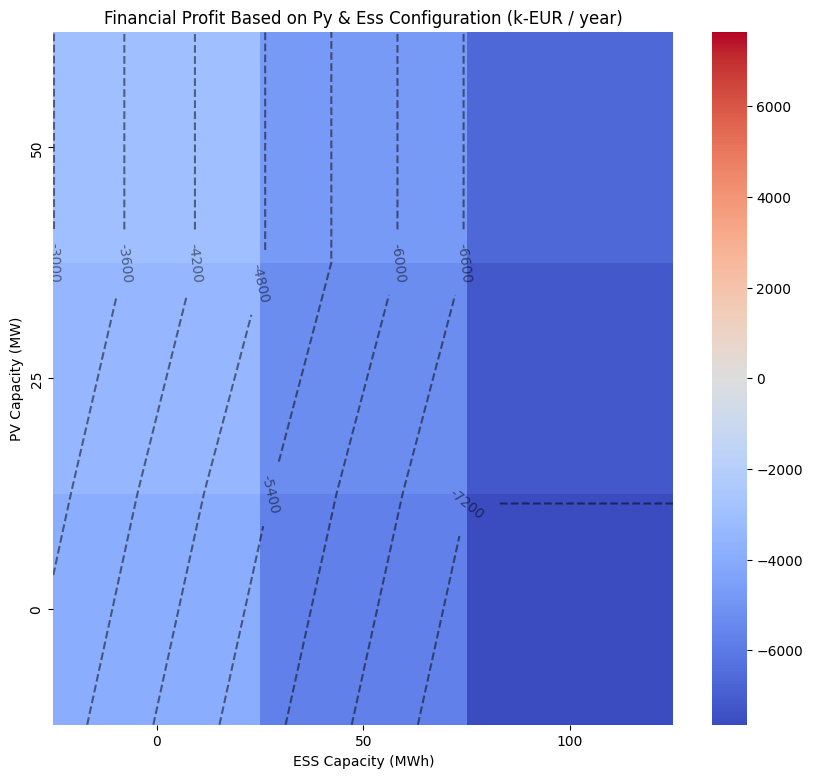

In [93]:
from tqdm import tqdm
months_results = []
months_costs = []
months_overload = []
months_nettos = []
months_gen_energy = []
months_gen_energy2 = []
months_ess_rest = pd.DataFrame(30, index=pv_capacities, columns= ess_capacities)
months_csv_data = {}
for index, month_data in tqdm(enumerate(months_data), total=len(months_data), position=0, leave= True):
    results = pd.DataFrame(index=pv_capacities, columns= ess_capacities)
    costs = pd.DataFrame(index=pv_capacities, columns= ess_capacities)
    overload_cnt = pd.DataFrame(index=pv_capacities, columns= ess_capacities)
    nettos = pd.DataFrame(index=pv_capacities, columns= ess_capacities)
    gen_energies = pd.DataFrame(index=pv_capacities, columns= ess_capacities)
    gen_energies2 = pd.DataFrame(index=pv_capacities, columns= ess_capacities)
    factory_demands = {}
    buy_prices= {}
    sell_prices = {}
    pv_generates = {}
    grid_need_powers = {}
    times = {}
    for pv_capacity in tqdm(pv_capacities, total=len(pv_capacities), desc=f'generating pv for month {index + 1}',position=1, leave=False):
        factory_demands[pv_capacity] = {}
        buy_prices[pv_capacity] = {}
        sell_prices[pv_capacity] = {}
        pv_generates[pv_capacity] = {}
        grid_need_powers[pv_capacity] = {}
        times[pv_capacity] = {}
        for ess_capacity in ess_capacities:
            (result, 
             overload, 
             cost, 
             netto,
             gen_energy,
             gen_energy2,
             ess_rest,
             factory_demand,
             buy_price,
             sell_price,
             pv_generate,
             grid_need_power,
             time) = generate_data(pv_capacity=pv_capacity,
                        pv_cost_per_kW=pv_cost_per_kW,
                        pv_lifetime=pv_lifetime, 
                        pv_loss=pv_loss, 
                        ess_capacity=ess_capacity, 
                        ess_cost_per_kW=ess_cost_per_kW, 
                        ess_lifetime=ess_lifetime, 
                        ess_loss=ess_loss, 
                        grid_capacity=grid_capacity, 
                        grid_loss=grid_loss, 
                        sell_price=sell_price, 
                        time_interval=time_interval, 
                        data=month_data, 
                        days=months_days[index],
                        storage=months_ess_rest.loc[pv_capacity, ess_capacity])
            results.loc[pv_capacity,ess_capacity] = result
            overload_cnt.loc[pv_capacity,ess_capacity] = overload
            costs.loc[pv_capacity,ess_capacity] = cost
            nettos.loc[pv_capacity,ess_capacity] = netto
            gen_energies.loc[pv_capacity, ess_capacity] = gen_energy
            gen_energies2.loc[pv_capacity, ess_capacity] = gen_energy2
            months_ess_rest.loc[pv_capacity, ess_capacity] = ess_rest
            factory_demands[pv_capacity][ess_capacity] = factory_demand
            buy_prices[pv_capacity][ess_capacity] = buy_price
            sell_prices[pv_capacity][ess_capacity] = sell_price
            pv_generates[pv_capacity][ess_capacity] = pv_generate
            grid_need_powers[pv_capacity][ess_capacity] = grid_need_power
            times[pv_capacity][ess_capacity] = time
    months_csv_data[index] = {"factory_demand": factory_demands, "buy_price": buy_prices, "sell_price": sell_prices, "pv_generate": pv_generates, "grid_need_power": grid_need_powers, "time": times}
    months_results.append(results)
    months_costs.append(costs)
    months_overload.append(overload_cnt)
    months_nettos.append(nettos)
    months_gen_energy.append(gen_energies)
    months_gen_energy2.append(gen_energies2)
    draw_results(results=results, 
                    filename=f'plots/pv-{pv_capacity}-ess-{ess_capacity}-month-{index+1}-benefit.png',
                    title_benefit=title_benefit,
                    annot_benefit=annot_benefit,
                    figure_size=figure_size)
    draw_overload(overload_cnt=overload_cnt, 
                    filename=f'plots/pv-{pv_capacity}-ess-{ess_capacity}-month-{index+1}-unmet.png',
                    title_unmet=title_unmet,
                    annot_unmet=annot_unmet,
                    figure_size=figure_size,
                    days=months_days[index],
                    granularity=granularity)
annual_result = pd.DataFrame(index=pv_capacities, columns= ess_capacities)
annual_costs = pd.DataFrame(index=pv_capacities, columns= ess_capacities)
annual_overload = pd.DataFrame(index=pv_capacities, columns= ess_capacities)
annual_nettos = pd.DataFrame(index=pv_capacities, columns= ess_capacities)
annual_gen = pd.DataFrame(index=pv_capacities, columns= ess_capacities)
annual_gen2 = pd.DataFrame(index=pv_capacities, columns= ess_capacities)


# get the yearly results
for pv_capacity in pv_capacities:
    for ess_capacity in ess_capacities:
        results = 0
        costs = 0
        overload_cnt = 0
        nettos = 0
        gen = 0
        gen2 = 0
        for index, month_data in enumerate(months_data):
            results += months_results[index].loc[pv_capacity,ess_capacity]
            costs += months_costs[index].loc[pv_capacity,ess_capacity]
            overload_cnt += months_overload[index].loc[pv_capacity, ess_capacity]
            nettos += months_nettos[index].loc[pv_capacity, ess_capacity]
            gen += months_gen_energy[index].loc[pv_capacity, ess_capacity]
            gen2 += months_gen_energy[index].loc[pv_capacity, ess_capacity]
        annual_result.loc[pv_capacity, ess_capacity] = results
        annual_costs.loc[pv_capacity, ess_capacity] = costs
        annual_overload.loc[pv_capacity, ess_capacity] = overload_cnt
        annual_nettos.loc[pv_capacity, ess_capacity] = nettos
        annual_gen.loc[pv_capacity, ess_capacity] = gen
        annual_gen2.loc[pv_capacity, ess_capacity] = gen2

draw_cost(costs=annual_costs,
          filename='plots/annual_cost.png',
        title_cost=title_cost,
        annot_cost=annot_cost,
        figure_size=figure_size)
draw_results(results=annual_result,
                filename='plots/annual_benefit.png',
                title_benefit=title_benefit,
                annot_benefit=annot_benefit,
                figure_size=figure_size)
draw_overload(overload_cnt=annual_overload,
                filename='plots/annual_unmet.png',
                title_unmet=title_unmet,
                annot_unmet=annot_unmet,
                figure_size=figure_size)

In [94]:
def collapse_months_csv_data(months_csv_data, column_name,pv_capacies, ess_capacities):
    data = {}
    for pv_capacity in pv_capacities:
        data[pv_capacity] = {}
        for ess_capacity in ess_capacities:
            annual_data = []
            for index, month_data in enumerate(months_data):
                annual_data.extend(months_csv_data[index][column_name][pv_capacity][ess_capacity])
                # months_csv_data[index][column_name][pv_capacity][ess_capacity] = months_csv_data[index][column_name][pv_capacity][ess_capacity].tolist()

            data[pv_capacity][ess_capacity] = annual_data
    return data 

In [102]:
annual_pv_gen = collapse_months_csv_data(months_csv_data, "pv_generate", pv_capacities, ess_capacities)
annual_time = collapse_months_csv_data(months_csv_data, "time", pv_capacities, ess_capacities)
annual_buy_price = collapse_months_csv_data(months_csv_data, "buy_price",pv_capacities, ess_capacities)
annual_sell_price = collapse_months_csv_data(months_csv_data, "sell_price", pv_capacities, ess_capacities)
annual_factory_demand = collapse_months_csv_data(months_csv_data, "factory_demand", pv_capacities, ess_capacities)
annual_grid_need_power = collapse_months_csv_data(months_csv_data, "grid_need_power", pv_capacities, ess_capacities)

from datetime import datetime, timedelta

for pv_capacity in pv_capacities:
    for ess_capacity in ess_capacities:
        with open(f'data/annual_data-pv-{pv_capacity}-ess-{ess_capacity}.csv', 'w') as f:
            f.write("date, time,pv_generate (kW),factory_demand (kW),buy_price (USD/MWh),sell_price (USD/MWh),grid_need_power (kW)\n")
            start_date = datetime(2023, 1, 1, 0, 0, 0)
            for i in range(len(annual_time[pv_capacity][ess_capacity])):
                current_date = start_date + timedelta(hours=i)
                formate_date = current_date.strftime("%Y-%m-%d")
                f.write(f"{formate_date},{annual_time[pv_capacity][ess_capacity][i]},{int(annual_pv_gen[pv_capacity][ess_capacity][i])},{int(annual_factory_demand[pv_capacity][ess_capacity][i])},{int(annual_buy_price[pv_capacity][ess_capacity][i]*1000)},{int(annual_sell_price[pv_capacity][ess_capacity][i]*1000)},{int(annual_grid_need_power[pv_capacity][ess_capacity][i])} \n")



In [96]:
def save_data(data, filename):
    data.to_csv(filename+'.csv')
    data.to_json(filename + '.json')

In [97]:
if not os.path.isdir('data'):
    os.makedirs('data')

save_data(annual_result, f'data/{pv_begin}-{pv_end}-{pv_groups}-{ess_begin}-{ess_end}-{ess_groups}-results')
save_data(annual_costs, f'data/{pv_begin}-{pv_end}-{pv_groups}-{ess_begin}-{ess_end}-{ess_groups}-costs')
save_data(annual_overload, f'data/{pv_begin}-{pv_end}-{pv_groups}-{ess_begin}-{ess_end}-{ess_groups}-overload_cnt')

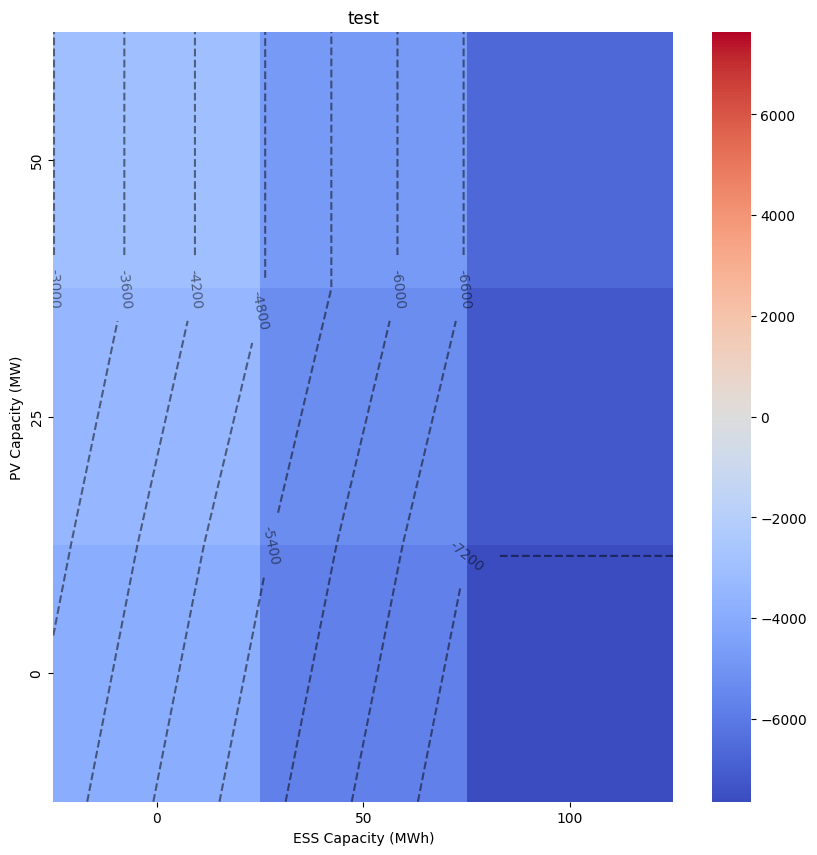

In [98]:
draw_results(annual_result, 'plots/test.png', 'test', False)

In [99]:
draw_roi(annual_costs, annual_nettos, 'plots/annual_roi.png',  title_roi, 365, annot_benefit, figure_size)
